In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import Explore as Ex
import plotly
from plotly.graph_objs import Scatter, Layout
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from pivottablejs import pivot_ui

In [2]:
dataset = pd.read_csv('../Arthena/task/data.csv',encoding="latin-1")

### Data Cleaning

#### Drop rows without hammer_price column value at the initial attempt

In [3]:
dataset = dataset.drop(dataset[dataset.hammer_price.isnull()].index)

#### Check the missing value of each column

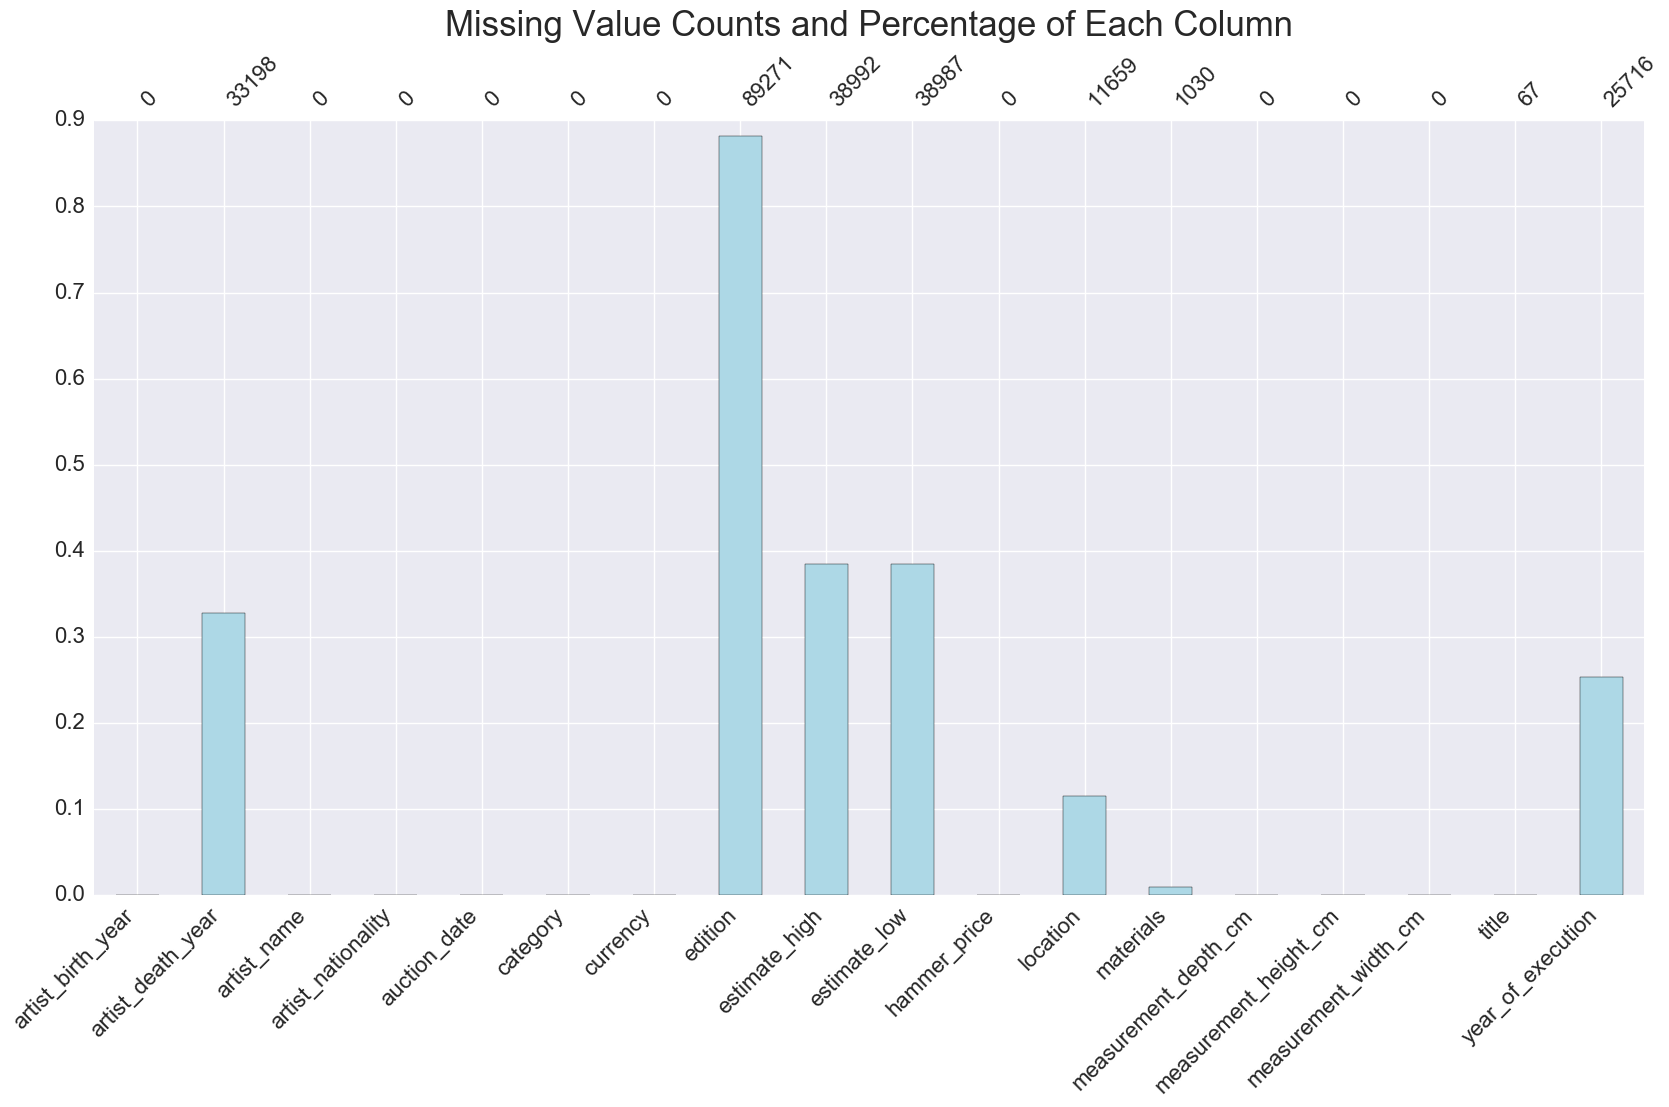

In [4]:
Ex.missing_value_bar(dataset,color="lightblue",title_string = "Missing Value Counts and Percentage of Each Column")

#### Drop column with 50% of missing value

In [5]:
check_null = dataset.isnull().sum(axis=0).sort_values(ascending=False)/float(len(dataset))
dataset.drop(check_null[check_null>0.5].index, axis=1, inplace=True)
drop_column = check_null[check_null>0.5].index.tolist()

#### Check how unique the each column is 

In [6]:
counts = np.array([len(dataset[col].value_counts()) for col in dataset.columns])
counts

array([   70,    43,   119,    17,  5153,    15,     3,   264,   243,
        1646,   217, 12257,   197,   396,   475, 35347,   988])

#### Remove Columns with little information
* `measurement_depth_cm` is 0 for 91.52% of the records (Drop for now and may categorize it later)
* `title` provides little information right now.(May be useful to do some NLP)

In [7]:
delete_me = ['measurement_depth_cm','title']
drop_column = drop_column + delete_me
dataset.drop(delete_me , axis=1, inplace=True) 

### Feature transformations

#### Modify the `year_of_execution` column

In [8]:
len(dataset['year_of_execution'].value_counts())

988

In [9]:
dataset['year_of_execution'] = dataset.year_of_execution.str.extract(r"(\d{4})")

/Users/chenchaozang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



In [10]:
len(dataset['year_of_execution'].value_counts())

212

In [47]:
dataset.ix[pd.to_numeric(dataset['year_of_execution'])>2016,'year_of_execution'] = 2016

#### Drop the `estimate_high` and `estimate_low` columns
* Over 30% of records are missing in estimate_high and estimate_low
* These two columns may lead to information leakage

#### Modify the auction date

In [11]:
dataset['auction_year'] = dataset['auction_date'].str.split('-').str[0]
dataset['auction_month'] = dataset['auction_date'].str.split('-').str[1]
dataset.ix[dataset.auction_month>'06','auction_month'] = 'Fall'
dataset.ix[dataset.auction_month<='06','auction_month'] = 'Spring'
dataset.drop('auction_date' , axis=1, inplace=True) 
drop_column.append('auction_date')

In [12]:
dataset.dtypes

artist_birth_year          int64
artist_death_year        float64
artist_name               object
artist_nationality        object
category                  object
currency                  object
estimate_high            float64
estimate_low             float64
hammer_price             float64
location                  object
materials                 object
measurement_height_cm      int64
measurement_width_cm       int64
year_of_execution         object
auction_year              object
auction_month             object
dtype: object

#### Get the artist age

In [13]:
dataset.ix[dataset.artist_death_year.isnull(),'artist_death_year'] = 2013
dataset['artist_age'] = dataset.artist_death_year - dataset.artist_birth_year
dataset.drop('artist_birth_year' , axis=1, inplace=True)
dataset.drop('artist_death_year' , axis=1, inplace=True)
drop_column.append('artist_birth_year')
drop_column.append('artist_death_year')

#### Get the period between auction `year` and `year_of_execution`

#### Drop the material column first

#### Solution to work on `material` column

* For non-linear algorithms like RF you can also replace a categorical variable by the number of times it appears in the train set. This turns it into a single feature.

* 

In [14]:
dataset.drop('materials' , axis=1, inplace=True)

In [15]:
# dataset['materials'] = dataset['materials'].str.lower()
# dataset['materials'] = dataset['materials'].str.strip('.')
# dataset['materials'] = dataset['materials'].str.strip(',')

In [16]:
# dataset.materials.value_counts()[dataset.materials.value_counts()>50]

In [17]:
# fracs = dataset.materials.value_counts()[dataset.materials.value_counts()>50].tolist()
# labels = dataset.materials.value_counts()[dataset.materials.value_counts()>50].index.tolist()

In [18]:
# plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

### Data Exploration

In [19]:
pivot_ui(dataset.sample(frac=0.1))

In [20]:
price = dataset.hammer_price
data = dataset.drop("hammer_price", axis=1)

In [21]:
from sklearn.model_selection import train_test_split
data_train, data_test, price_train, price_test = train_test_split(
    data,  price, random_state=1)

In [22]:
dataset.dtypes

artist_name               object
artist_nationality        object
category                  object
currency                  object
estimate_high            float64
estimate_low             float64
hammer_price             float64
location                  object
measurement_height_cm      int64
measurement_width_cm       int64
year_of_execution         object
auction_year              object
auction_month             object
artist_age               float64
dtype: object

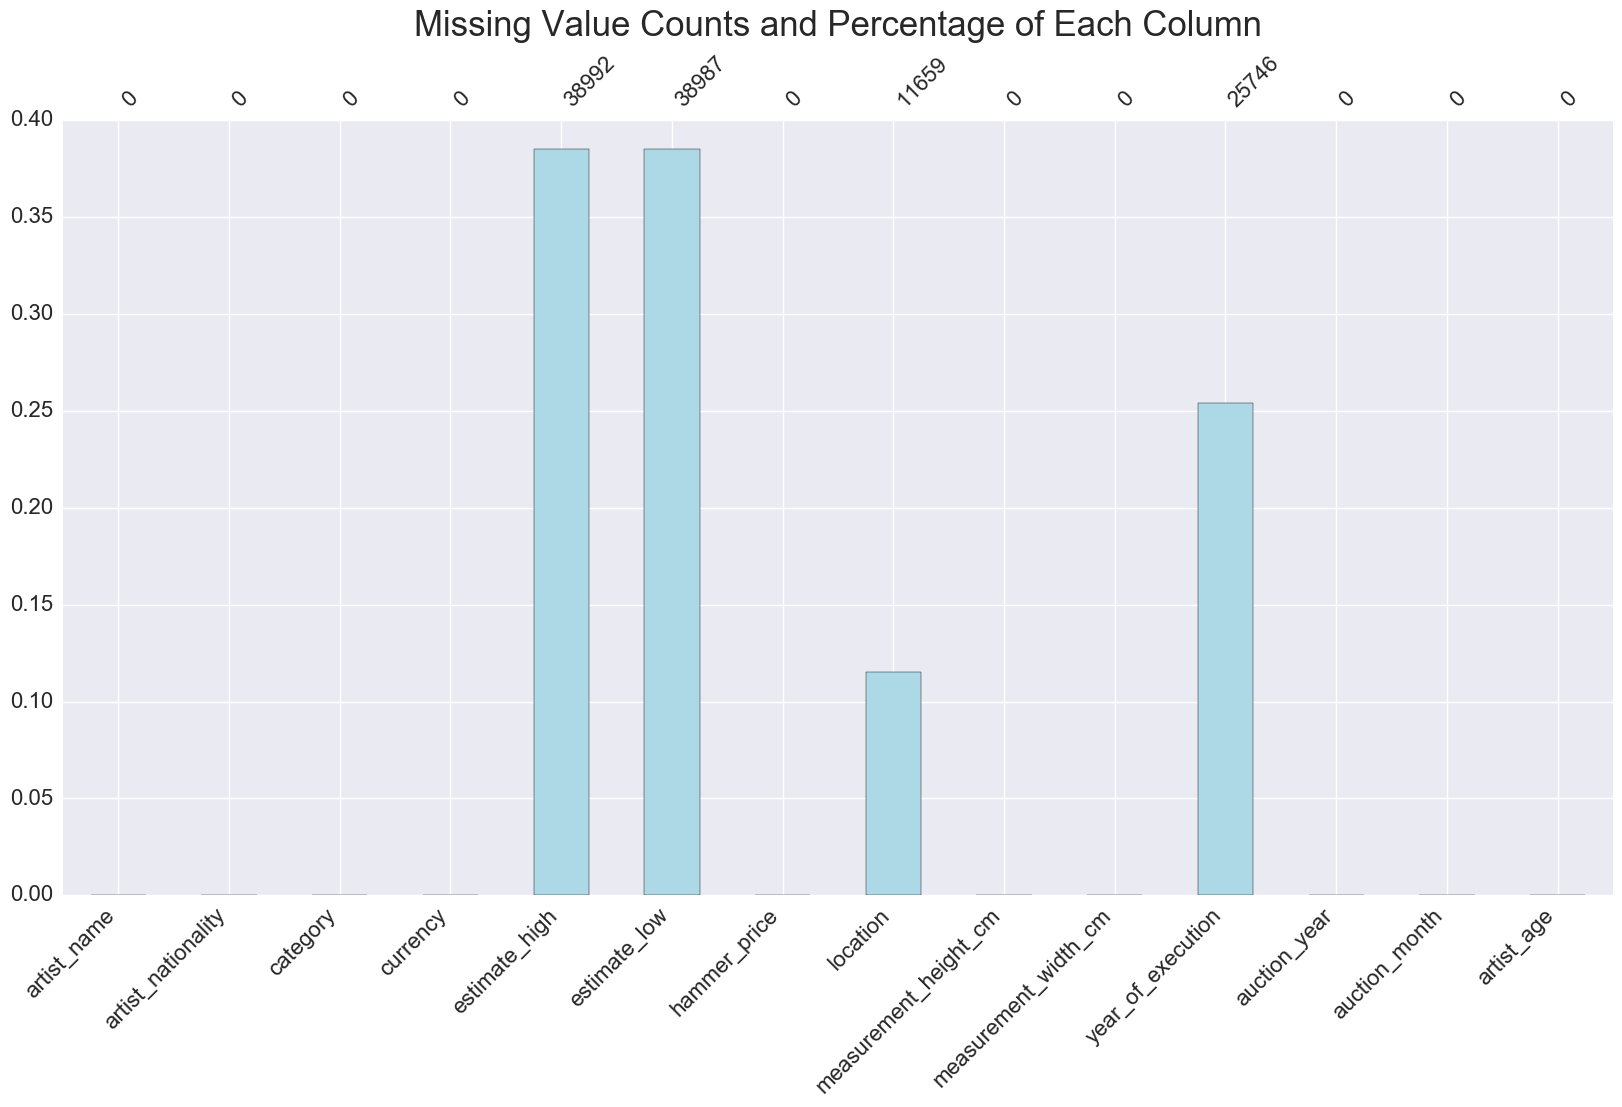

In [23]:
Ex.missing_value_bar(dataset,color="lightblue",title_string = "Missing Value Counts and Percentage of Each Column")

In [24]:
plotly.offline.init_notebook_mode(connected=True)

In [25]:
py.iplot(Ex.draw_pie(dataset,'category'))

In [26]:
py.iplot(Ex.draw_pie(dataset,'location'))

In [27]:
py.iplot(Ex.draw_pie(dataset,'currency'))

In [28]:
py.iplot(Ex.draw_pie(dataset,'artist_nationality'))

In [117]:
data_train_dummies = pd.get_dummies(data_train)

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
cross_val_score(RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3),
                data_train_dummies, price_train, cv=5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').